#Gather trajectories

In [5]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_transformed = map( lambda x: x-width/2 , x_raw )
y_transformed = map( lambda x: -height/2-x , y_raw )
domain = (-width/2,width/2,-height/2,height/2)

width = 1980.000000, height = 1093.000000


In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

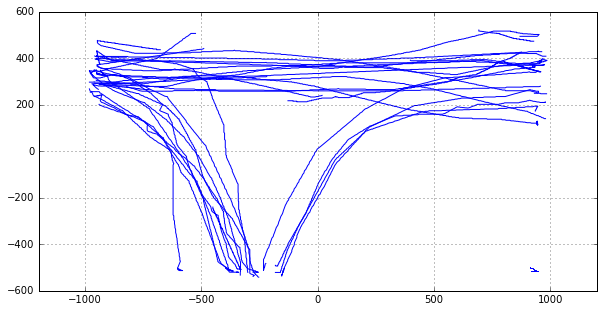

In [7]:
plt.figure(figsize=(10,5))
for k in range(len(x_transformed)):
    plt.plot(x_transformed[k],y_transformed[k],'b-')
plt.axis(domain)
plt.grid()
plt.axis('equal')
plt.show()

## Lagrangian
We consider Lagrangian's of the form
$$
    L(x,y,\dot{x},\dot{y};\theta) = \frac{1}{2} ( \dot{x}^2+\dot{y}^2) - (\partial_y \phi(x,y;\theta) \dot{x} - \partial_x \phi(x,y;\theta) \dot{y} )
$$
where
$$
    \phi(x,y;\theta) = \sum_{k_1,k_2} \theta_{k_1,k_2} H_{k_1}(\alpha_x x)H_{k_2}(\alpha_y y).
$$
The Euler-Lagrange equations are given by
$$
    \frac{d}{dt} \left(\dot{x} - \partial_y \phi \right) + \partial_{xy} \phi \dot{x} - \partial_{xx}\phi \dot{y} = 0 \\
    \frac{d}{dt} \left(\dot{y} + \partial_x \phi \right) + \partial_{yy} \phi \dot{x} - \partial_{xy}\phi \dot{y} = 0
$$
which simplifies to
$$
    \ddot{x} = \Delta \phi(x,y) \dot{y} \\
    \ddot{y} = -\Delta \phi(x,y) \dot{x}
$$
where $\Delta = \partial_{xx} + \partial_{yy}$


## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L( x,\dot{x} ; \theta) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    (q(i-1) - 2 q(i) + q(i+1)) + \begin{pmatrix} -1 \\ 1 \end{pmatrix} \Delta \phi( q(i) ) = 0.
$$
for $i=1,\dots,N-1$

## Training in a Hermite Polynomial Basis
In this section we consider potential functions of the form
$$
    V(x,y) = \sum_{k_1,k_2=0}^{K} \theta[k_1,k_2] H_{k_1}(x) H_{k_2}(y)
$$
where $H_k$ is the $k$th Hermite polynomial.
The gradients of $V$ is given by
$$
    \partial_x V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_1 H_{k_1-1}(x) H_{k_2}(y) \\
    \partial_y V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_2 H_{k_1}(x) H_{k_2-1}(y) \\
$$

In [9]:
curves = [ np.vstack([x_transformed[0][460:800:10], y_transformed[0][460:800:10]]) ]
curves.append( np.vstack( [ x_transformed[4][230:510:10],y_transformed[4][230:510:10] ] ) )
curves.append( np.vstack( [ x_transformed[6][290:580:10],y_transformed[6][290:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[13][170:300:10],y_transformed[13][170:300:10] ] ) )
curves.append( np.vstack( [ x_transformed[14][420:580:10], y_transformed[14][420:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[15][50:200:10],y_transformed[15][50:200:10] ] ) )
curves.append( np.vstack( [ x_transformed[17][400:680:10],y_transformed[17][400:680:10] ] ) )
curves.append( np.vstack( [ x_transformed[20][200:400:10],y_transformed[20][200:400:10] ] ) )
curves.append( np.vstack( [ x_transformed[22][370:650:10],y_transformed[22][370:650:10] ] ) )
curves.append( np.vstack( [ x_transformed[24][350:650:10],y_transformed[24][350:650:10] ] ) )

In [15]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for curve in curves:
        n = curve.shape[1] #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (k_max+1,k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,c in zip( x_list, y_list, curves):
        out += np.dot(x-c[0],x-c[0]) + np.dot(y-c[1],y-c[1])
    return out

def EL_constraint(decision_variables , curves, k_max ):
    global width,height
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for x,y in zip(x_list,y_list):
        n = x.size
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) )
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        from numpy.polynomial.hermite import hermder, hermval2d
        theta_xx = hermder( theta, m=2, axis=0 )
        theta_yy = hermder( theta, m=2, axis=1 )
        alpha_x = np.sqrt(2*k_max) / (width/2)
        alpha_y = np.sqrt(2*k_max) / (height/2)
        phi_xx = (alpha_x**2)*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_xx )
        phi_yy = (alpha_y**2)*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_yy )
        out_list += [a_x-phi_xx-phi_yy, a_y+phi_xx+phi_yy]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list) ):
        out[0][k] = curves[k][0,0] - x[0]
        out[1][k] = curves[k][0,-1] - x[-1]
        out[2][k] = curves[k][1,0] - y[0]
        out[3][k] = curves[k][1,-1] - y[-1]
    return out.flatten()

k_max = 4
constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

theta = np.zeros( (k_max+1, k_max+1) )
guess_list = []
for c in curves:
    x_guess = np.linspace(c[0,0],c[0,-1], len(c[0]))
    y_guess = np.linspace(c[1,0],c[1,-1], len(c[1]))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )

def cb_function(x):
    global k_max,curves
    print "Cost = %f" % cost_function(x, curves , k_max )
    return 0

#x_out,y_out,theta_out = get_xy_theta( initial_guess , curves, k_max)
#plt.plot(x_out[0],y_out[0])
#plt.plot(curves[0][0,:],curves[0][1,:])
#print theta_out
#print cost_function(initial_guess, curves, k_max)
#print EL_constraint(initial_guess, curves, k_max)
#print boundary_constraint(initial_guess, curves, k_max)
#print cb_function(initial_guess)

In [16]:
from scipy.optimize import minimize
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves, k_max ),
              callback = cb_function)
print res.message
x_list,y_list,theta_opt_magnetic = get_xy_theta( res.x , curves, k_max)

Cost = 3060256.648555
Cost = 1585898.655118
Cost = 1541903.558089
Cost = 1482596.079928
Cost = 1473510.860270
Cost = 1463800.050248
Cost = 1459339.582692
Cost = 1453803.458676
Cost = 1447810.502085
Cost = 1443657.761999
Cost = 1441194.049249
Cost = 1438206.645404
Cost = 1434448.447015
Cost = 1432221.086290
Cost = 1430791.493418
Cost = 1429412.992420
Cost = 1428712.656131
Cost = 1428283.201247
Cost = 1428010.540606
Cost = 1427030.476120
Cost = 1425471.348247
Cost = 1424341.894748
Cost = 1423493.353359
Cost = 1422833.681132
Cost = 1422389.862637
Cost = 1422119.159173
Cost = 1421988.672229
Cost = 1421911.903103
Cost = 1421848.661161
Cost = 1421785.031736
Cost = 1421707.011755
Cost = 1421594.167130
Cost = 1421392.878021
Cost = 1421031.275563
Cost = 1420446.282260
Cost = 1419617.526043
Cost = 1418554.887271
Cost = 1417312.434342
Cost = 1415958.042396
Cost = 1414599.663489
Cost = 1413354.452813
Cost = 1412278.899730
Cost = 1411460.836475
Cost = 1410844.661287
Cost = 1410472.308420
Cost = 141

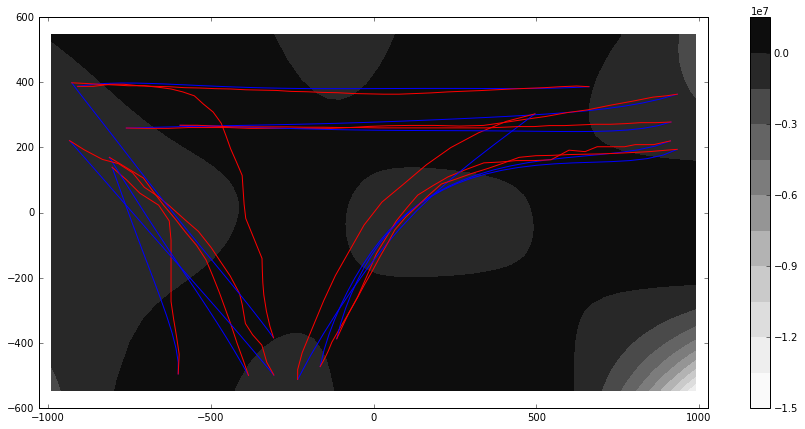

In [17]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
n_curves = len(curves)
from numpy.polynomial.hermite import hermval2d
alpha_x = np.sqrt(2*k_max) / (width/2)
alpha_y = np.sqrt(2*k_max) / (height/2)
V = hermval2d(alpha_x*x_grid , alpha_y*y_grid, theta_opt_magnetic)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 10,cmap='Greys')
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
axis_size= plt.axis('equal')

In [18]:
np.save('theta_opt_magnetic',theta_opt_magnetic)

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

In [24]:
def Stormer_Verlet(x0,x1,y0,y1,t_max):
    from numpy.polynomial.hermite import hermder
    theta_xx = hermder( theta_opt_magnetic, axis=0, m=2)
    theta_yy = hermder( theta_opt_magnetic, axis=1, m=2)
    x_pred = [x0,x1]
    y_pred = [y0,y1]
    for _ in range(2,t_max):
        x0,x1 = x_pred[-2], x_pred[-1]
        y0,y1 = y_pred[-2], y_pred[-1]
        phi_xx = (alpha_x**2)*hermval2d(alpha_x*x1 , alpha_y*y1, theta_xx )
        phi_yy = (alpha_y**2)*hermval2d(alpha_x*x1 , alpha_y*y1, theta_yy )
        x_pred.append( 2*x1 - x0 +phi_xx+phi_yy )
        y_pred.append( 2*y1 - y0 -phi_xx-phi_yy )
    return np.array(x_pred),np.array(y_pred)

In [45]:
curve_ind = 2
x0,x1 = x_list[curve_ind][0], x_list[curve_ind][1]
y0,y1 = y_list[curve_ind][0], y_list[curve_ind][1]
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1, len(x_list[curve_ind]))

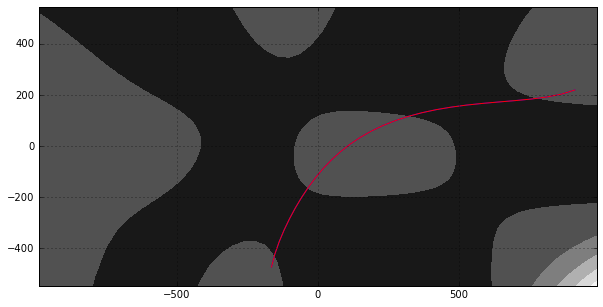

In [46]:
plt.figure(figsize = (10,5))
plt.contourf(x_grid,y_grid,V , 5,cmap='Greys')
plt.plot(x_list[curve_ind],y_list[curve_ind],'b-')
plt.plot(x_pred,y_pred,'r-')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)
plt.show()

## Predictions from Training Data
Now let's see if we can predict some of the red curves in the training data using a finite difference scheme to estimate the initial velocity

In [56]:
start = 6
x0 = curves[curve_ind][0,start]
x1 = x0 + 0.5*( curves[curve_ind][0,start+1] - curves[curve_ind][0,start-1] )
y0= curves[curve_ind][1,start]
y1 = y0 + 0.5*( curves[curve_ind][1,start+1] - curves[curve_ind][1,start-1] )
t_max = len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max)

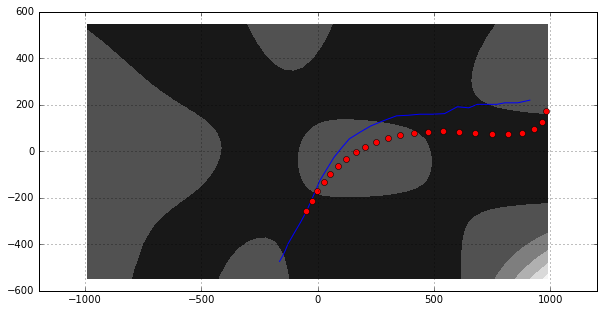

In [57]:
plt.figure(figsize = (10,5))
plt.contourf(x_grid,y_grid,V , 5,cmap='Greys')
plt.plot(curves[curve_ind][0],curves[curve_ind][1],'b-')
plt.plot(x_pred,y_pred,'ro')
#plt.axis([-width/2,width/2,-height/2,height/2])
plt.axis('equal')
plt.grid(True)

## Predictions on Test data
Let's do the same thing on some of the test data

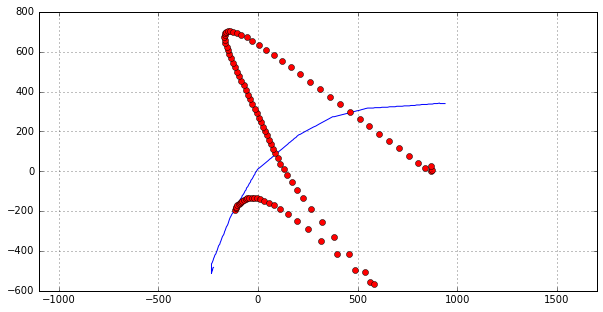

In [80]:
curve_ind = 15
start = 100
x0 = x_transformed[curve_ind][start]
x1 = x0 + ( x_transformed[curve_ind][start+3] - x_transformed[curve_ind][start-3] ) / float(6)
y0 = y_transformed[curve_ind][start]
y1 = y0 + ( y_transformed[curve_ind][start+3] - y_transformed[curve_ind][start-3] ) / float(6)
t_max = 100 #len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max)
fig = plt.figure(figsize=(10,5))
plt.plot(x_transformed[curve_ind], y_transformed[curve_ind],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.axis('equal')
plt.grid(True)